In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time as t
plt.style.use('seaborn-whitegrid')

credit = pd.read_csv('https://raw.githubusercontent.com/jzuver/Final-211/main/BankChurners.csv')

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]


def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

custom_workload = [(len(credit[credit['Customer_Age'] > 10])), 
                     (len(credit[credit['Customer_Age'] > 45])),
                    (len(credit[(credit['Customer_Age'] > 40) & (credit['Gender'] == 'M')])),
                   (len(credit[(credit['Customer_Age'] > 40) & (credit['Gender'] == 'F')])),
                   (len(credit[(credit['Customer_Age'] < 40) & (credit['Gender'] == 'F')])),
                   (len(credit[(credit['Customer_Age'] == 40) & (credit['Education_Level'] == 'Graduate')])),
                   (len(credit[credit['Marital_Status'] == 'Single']) & len(credit[credit['Gender'] == 'M'])),
                   (len(credit[credit['Marital_Status'] == 'Single']) & len(credit[credit['Gender'] == 'F'])),
                   (len(credit[credit['Dependent_count'] == 4])),
                   (len(credit[credit['Card_Category'] ==  'Blue'])),
                   (len(credit[credit['Education_Level'] ==  'Uneducated'])),
                    (len(credit[credit['Credit_Limit'] >  10000])),
                   (len(credit[credit['Months_on_book'] >  36])),
                   (len(credit[(credit['Customer_Age'] < 30) & (credit['Education_Level'] == 'High School')])),
                         (len(credit[(credit['Customer_Age'] > 30) & (credit['Card_Category'] == 'Silver')]))
                  ]
real_answers = custom_workload



## Vector-Valued Laplace Mechanism on Workload of Queries
Below we perform the vector-valued Laplace Mechanism on a workload of queries on multiple columns in the data, and the first 5 answers and average absolute error are displayed.

In [297]:
def workload_laplace_vec(workload, epsilon):
    # create parameters for range_query and list to store 
    noisy_vec_vals = laplace_mech_vec(workload, len(workload), epsilon)
    return noisy_vec_vals
print('First 5 answers:', workload_laplace_vec(custom_workload, 1.0)[:5])

First 5 answers: [10123.230965095976, 5490.023512370579, 3550.628650929644, 4100.087110966251, 1034.1317319210184]


In [298]:
Lerrors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(custom_workload, 1.0))]
print('Average absolute error:', np.mean(Lerrors))

Average absolute error: 16.350895674610644


## Vector-Valued Gaussian Mechanism on Workload of Queries
Below we perform the vector-valued Gaussiam Mechanism on a workload of queries on multiple columns in the data, and the first 5 answers and average absolute error are displayed.

In [299]:
def workload_gaussian_vec(workload, epsilon, delta):
    noisy_vec_vals = gaussian_mech_vec(workload, np.sqrt(len(workload)), epsilon, delta)
    return noisy_vec_vals
print('First 5 answers:', workload_gaussian_vec(custom_workload, 1.0, 1e-5)[:5])

First 5 answers: [10154.759465067293, 5457.486261301428, 3628.83776546974, 4116.515080448586, 1045.0702484662152]


In [300]:
Gerrors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(custom_workload, 1.0, 1e-5))]
print('Average absolute error:', np.mean(Gerrors))

Average absolute error: 17.710334876333288


## Analysis on Workload with k = 15 
Below we perform the workload_laplace_vec and workload_gaussian_vec functions 10,000 times each to get a better idea of what the true average absolute error is. As we can see from the results, when performing both mechanisms on the workload of $k$ = 15 1-sensitive results, the average absolute error appears to be very similar. 

In [337]:
def laplace_analysis(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(custom_workload, 1.0))])
    return accumulator / iterations    

In [338]:
laplace_analysis(10000)

14.968901241932102

In [339]:
def gaussian_analysis(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(custom_workload, 1.0, 1e-5))])
    return accumulator / iterations 

In [340]:
gaussian_analysis(10000)

14.989661746112615

## Analysis on Workload with k = 15000


In [383]:
# This function creates a workload that is the custom_workload 
# repeated 1000 times, for the purpose of testing larger workloads
def make_long_workload(iterations):
    long_workload = []
    for i in range(iterations):
        for i in custom_workload:
            long_workload.append(i)
    return long_workload

In [384]:
# create workload with k = 15,000
long_workload = make_long_workload(1000)

In [392]:
def gaussian_analysis_long(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(long_workload, 1.0, 1e-5))])
    return accumulator / iterations 

In [393]:
gaussian_analysis_long(1000)

471.41095203107676

In [394]:
def laplace_analysis_long(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(long_workload, 1.0))])
    return accumulator / iterations    

In [395]:
laplace_analysis_long(1000)

14805.935618510573

time for laplace  analysis: 0.06196610000006331
time for Gaussian analysis: 0.885108799999216


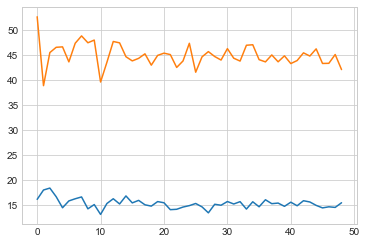

In [372]:
vec1 = []
vec2 = []
startL = t.perf_counter()
for x in range(1, 50):
    vec1.append(laplace_analysis(x))
endL = t.perf_counter()
dL = endL-startL
startG = t.perf_counter()
for x in range(1, 50):
    vec2.append(gaussian_analysis(x))
endG = t.perf_counter()
dG = endG-startG
plt.plot(vec1)
plt.plot(vec2)
print("time for laplace  analysis:", dL)
print("time for Gaussian analysis:", dG)